# Fetal Health Classification

Analysis of the dataset of CTG data is the first step.

In [1]:
%reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

np.random.seed(0)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Preliminary Exploration of the dataset

*DataFrame.describe()* method generates descriptive statistics for only numeric values not for categorical values. This method summarizes the central tendency, dispersion, and shape of a dataset’s distribution, excluding NaN values.

In [2]:
data = pd.read_csv("../dataset/fetal_health.csv")
data.info()
data.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


In [3]:
data.isnull().sum().sum()

0

The dataset contains non-null values and non-empty values

In [4]:
# Count the elements value to check the class imbalance
data.fetal_health.value_counts()

1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64

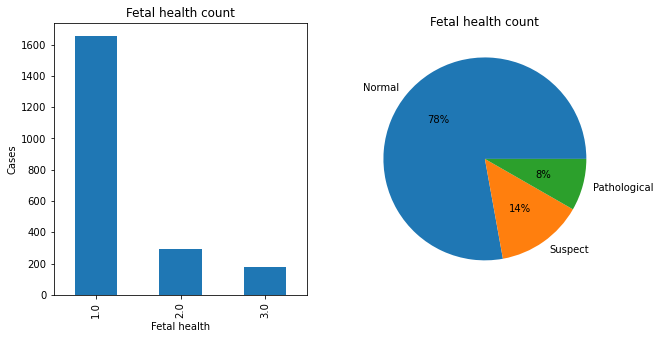

In [5]:
# Check the presence of data imbalance which requires careful attention during the validation of the final results of the models. In particular it tends to provide misleading calssification accuracy
plt.figure(figsize = (10,5))
plt.subplot(121)
vis_fetal_health = data.fetal_health.value_counts().plot(figsize=(10, 5), kind="bar")
plt.title("Fetal health count")
plt.xlabel("Fetal health")
plt.ylabel("Cases")

# Copied from value counts
normal = 1655
suspect = 295
pathological = 176
plt.subplot(122)
plt.title("Fetal state") 
vis_pie_fetal_health = plt.pie([normal, suspect, pathological], labels=["Normal", "Suspect", "Pathological"], autopct="%1.0f%%")
plt.title("Fetal health count")
plt.show()

Having verified the presence of class imbalance we will use different performance measures for our models:
* Precision
* Accuracy 
* Recall
* Confusion Matrix
* F1 Score

Let's check the correlation between the features of the dataset to consider a possible selection of the features

<AxesSubplot:>

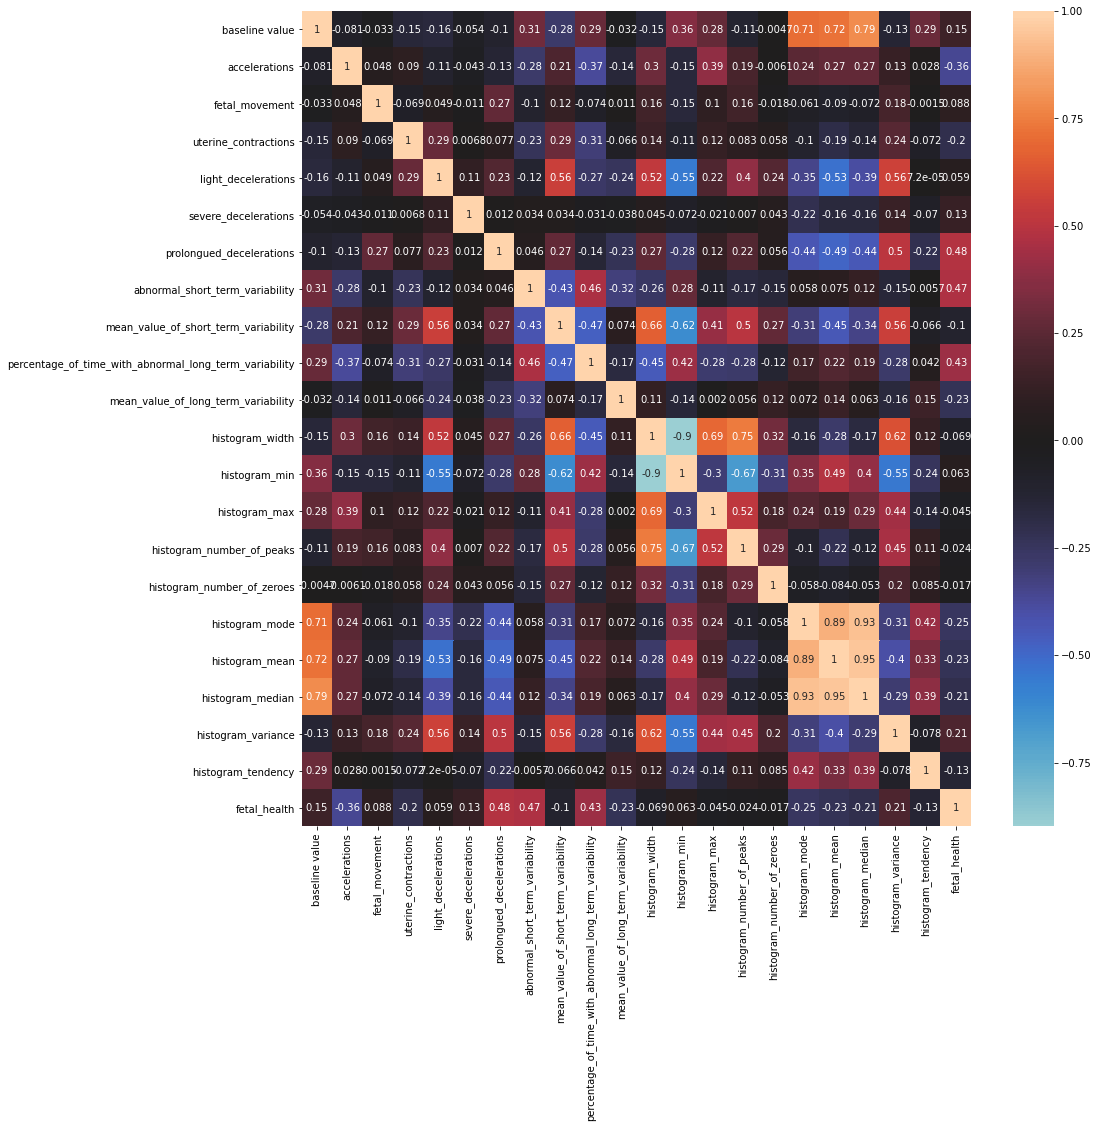

In [6]:
corrmat= data.corr()
plt.figure(figsize=(15,15))  
sns.heatmap(corrmat,annot=True,center=0)

We can that the values of "accelerations","prolongued_decelerations", "abnormal_short_term_variability", "percentage_of_time_with_abnormal_long_term_variability" and "mean_value_of_long_term_variability" are the features with high correlation with fetal_health. Let's say that we can consider features with correlation higher than 30% (we will consider it later in this notebook)

array([[<AxesSubplot:title={'center':'baseline value'}>,
        <AxesSubplot:title={'center':'accelerations'}>,
        <AxesSubplot:title={'center':'fetal_movement'}>],
       [<AxesSubplot:title={'center':'uterine_contractions'}>,
        <AxesSubplot:title={'center':'light_decelerations'}>,
        <AxesSubplot:title={'center':'severe_decelerations'}>],
       [<AxesSubplot:title={'center':'prolongued_decelerations'}>,
        <AxesSubplot:title={'center':'abnormal_short_term_variability'}>,
        <AxesSubplot:title={'center':'mean_value_of_short_term_variability'}>],
       [<AxesSubplot:title={'center':'percentage_of_time_with_abnormal_long_term_variability'}>,
        <AxesSubplot:title={'center':'mean_value_of_long_term_variability'}>,
        <AxesSubplot:title={'center':'histogram_width'}>],
       [<AxesSubplot:title={'center':'histogram_min'}>,
        <AxesSubplot:title={'center':'histogram_max'}>,
        <AxesSubplot:title={'center':'histogram_number_of_peaks'}>],
    

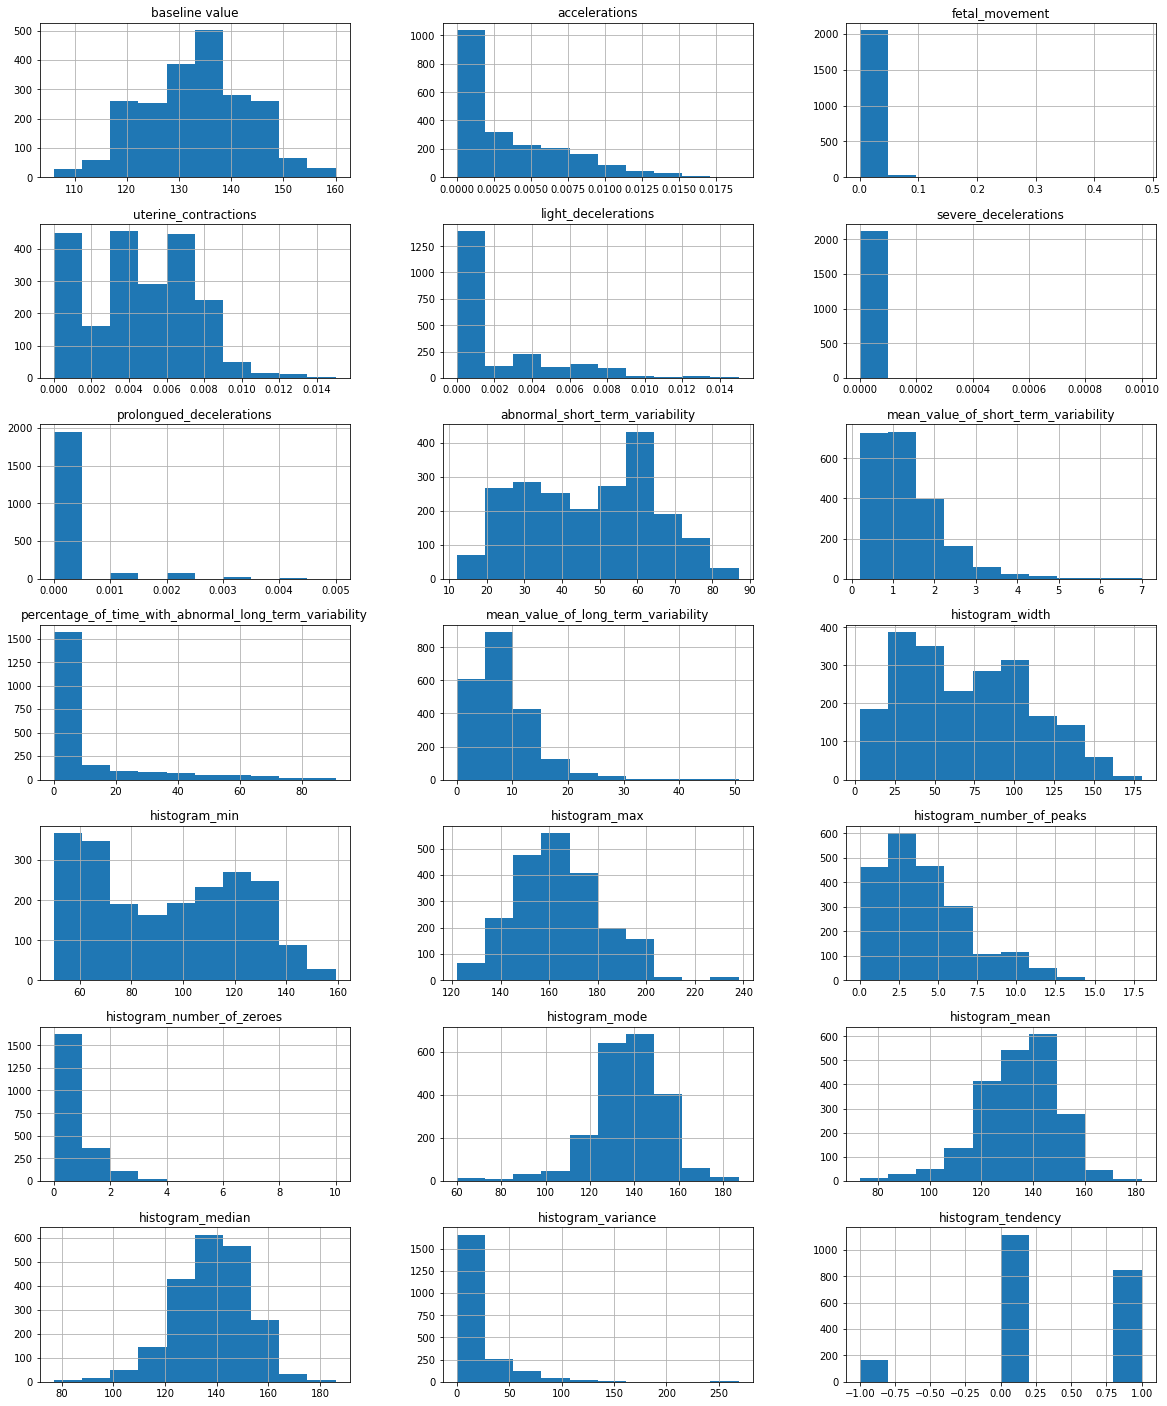

In [7]:
# Check skeweness of the features using histogram rappresentation
data.iloc[:,:-1].hist(figsize=[20,25], layout=[7,3])

We could clearly see that at least 8 features are extremely skewed and contain a significant amount of outliers.  In order to assure a flawless performance of the classifiers models we will scale every feature by standardization.

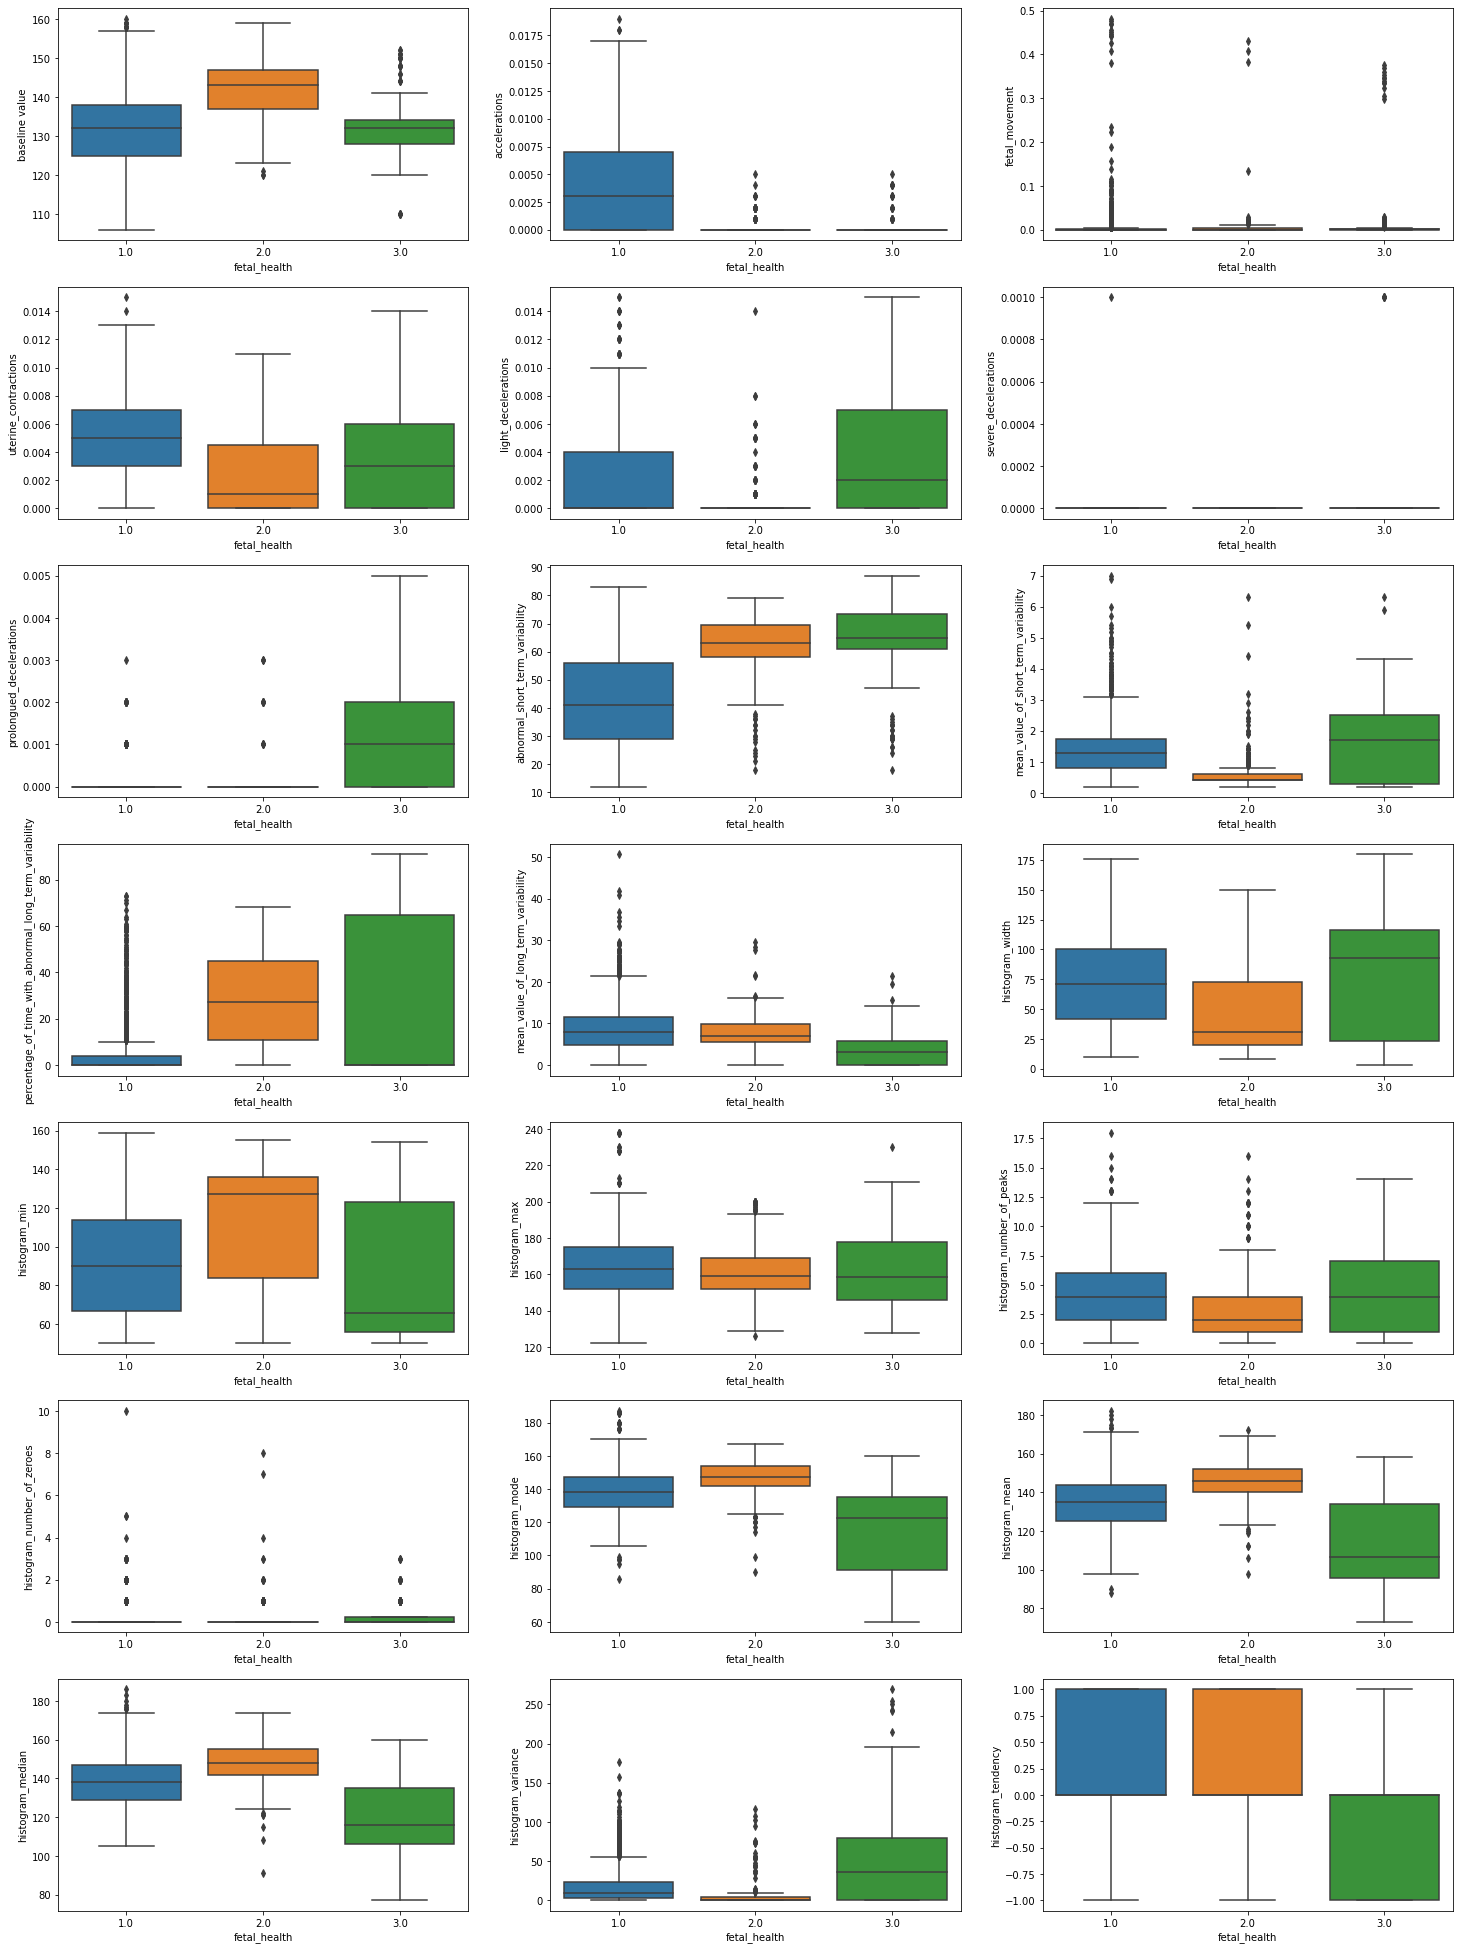

In [8]:
plt.figure(figsize=(25,35))
i=1
for feat in data.iloc[:,:-1].columns:
    plt.subplot(7,3,i)
    sns.boxplot(x='fetal_health',y=feat,data=data)
    i+=1

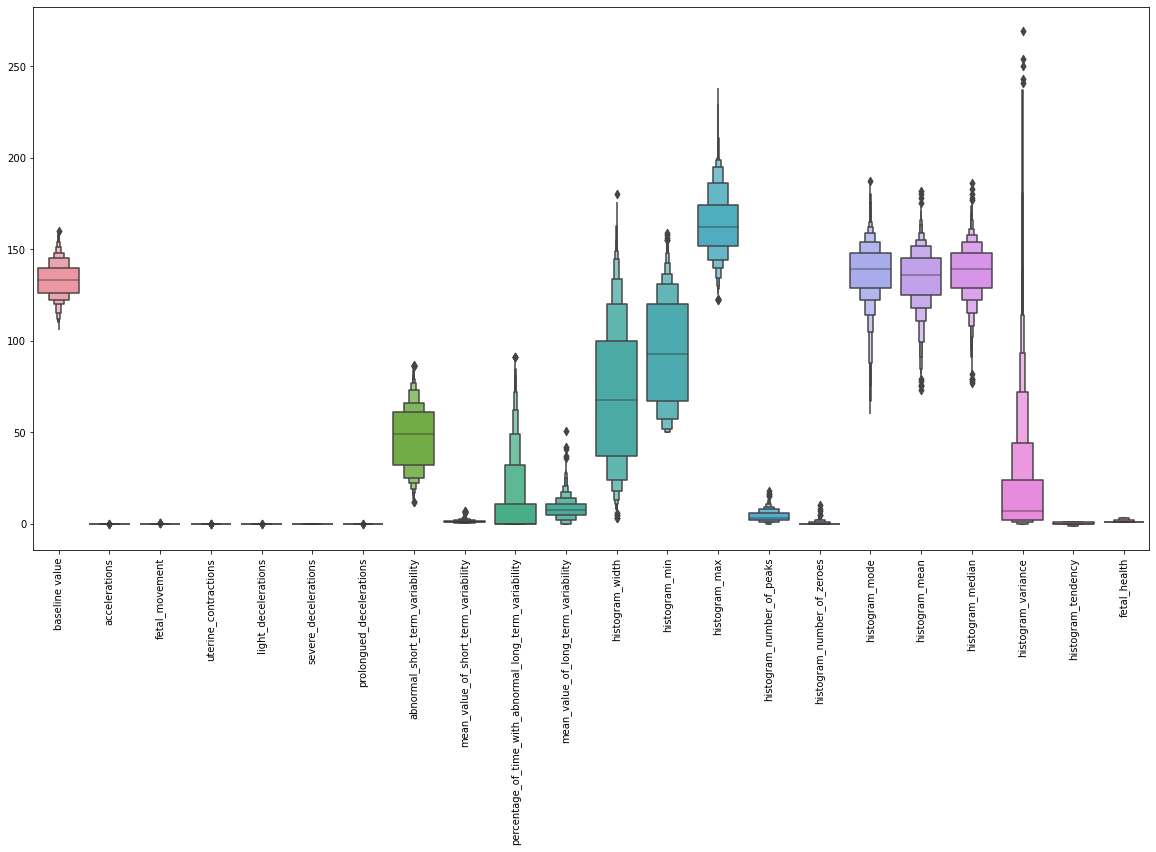

In [9]:
# Check if we need scaling of the features
plt.figure(figsize=(20,10))
sns.boxenplot(data = data)
plt.xticks(rotation=90)
plt.show()

In order to solve the problem of class imbalance several options are possible:
- Oversampling
- Undersampling
- Use the model with a different class_weights in order to account the class imbalance

Since the dataset is pretty limited we are going to use oversampling.

# Model evaluation using different class weights

In [10]:
# X_train, X_test, y_train,y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=42)

# # Check balance test set and train set
# print("Test set")
# print(y_test.value_counts())
# print("Traning set")
# print(y_train.value_counts())

# # Hardcoded number of values per class in the training set
# # It's clear that we have a problem with the second class which is has precision 0
# one = 1159
# two = 194
# three = 135
# s = one + two + three
# one /= s
# two /= s
# three /= s

# # This comes from the actual dataset but we have still problem with the second class with 0 precision
# #one = 0.78
# #two = 0.14
# #three = 0.08

# class_weight = { 1.0:one, 2.0:two, 3.0:three}
# pipeline_svm_linear=Pipeline([('svm_classifier_linear',SVC(kernel='linear', class_weight=class_weight))])
# pipeline_svm_poly=Pipeline([('svm_classifier_poly',SVC(kernel='poly',class_weight=class_weight))])
# pipeline_svm_rbf=Pipeline([('svm_classifier_rbf',SVC(kernel='rbf',class_weight=class_weight))])
# pipeline_svm_sigmoid=Pipeline([('svm_classifier_sigmoid',SVC(kernel='sigmoid',class_weight=class_weight))])
# pipeline_gaussian=Pipeline([('gaussian_classifier',GaussianNB())])

# pipelines = [
#     pipeline_svm_linear, 
#     pipeline_svm_poly, 
#     pipeline_svm_rbf, 
#     pipeline_svm_sigmoid,
#     pipeline_gaussian,
# ]

# pipe_dict = {
#     0: 'SVM linear', 
#     1: 'SVM poly', 
#     2: 'SVM rbf', 
#     3: "SVM sigmoid",
#     4: "Gaussian NB",
# }

# for pipe in pipelines:
#     pipe.fit(X_train, y_train)

# for i, model in enumerate(pipelines):
#     predictions=model.predict(X_test)
#     print("%s" % (pipe_dict[i]))
#     print(classification_report(y_test, predictions))
#     plt.subplots(figsize=(12,8))
#     cf_matrix = confusion_matrix(y_test, predictions)
#     sns.heatmap(cf_matrix, annot = True, fmt='g')
#     plt.show()      

In [13]:
X = data.drop(["fetal_health"], axis=1)
y = data["fetal_health"]

X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [15]:
# I am going to use SMOTE to perform the oversampling 
# References:
#   - https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
#   - https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
! pip install imblearn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train,  y_train)
print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())

(3477, 21)
(3477,)
2.0    1159
1.0    1159
3.0    1159
Name: fetal_health, dtype: int64


In [16]:
# Drop duplication
# X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# print(X_train.shape)
# print(X_test.shape)

# Apply standard scaler and verify the result
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape)
print(X_test.shape)
X_train = pd.DataFrame(X_train, columns=list(X.columns))
X_test = pd.DataFrame(X_test, columns=list(X.columns))
X_train.describe().T


(3477, 21)
(638, 21)


,count,mean,std,min,25%,50%,75%,max
baseline value,3477.0,-6.948074e-16,1.000144,-3.003502,-0.640368,-0.072651,0.810241,2.544724
accelerations,3477.0,6.539364e-17,1.000144,-0.519697,-0.519697,-0.519697,0.146160,5.473017
fetal_movement,3477.0,3.269682e-17,1.000144,-0.266117,-0.266117,-0.252815,-0.202292,7.769098
uterine_contractions,3477.0,3.269682e-17,1.000144,-1.197236,-0.936246,-0.118358,0.764104,3.706115
light_decelerations,3477.0,2.452261e-17,1.000144,-0.629293,-0.629293,-0.629293,0.352866,4.281505
severe_decelerations,3477.0,-2.452261e-17,1.000144,-0.111052,-0.111052,-0.111052,-0.111052,10.633913
prolongued_decelerations,3477.0,-3.269682e-17,1.000144,-0.482287,-0.482287,-0.482287,-0.482287,4.541480
abnormal_short_term_variability,3477.0,0.000000e+00,1.000144,-2.572131,-0.698597,0.275684,0.601322,1.818964
mean_value_of_short_term_variability,3477.0,-1.430486e-16,1.000144,-1.029999,-0.828662,-0.325319,0.681367,5.815467
percentage_of_time_with_abnormal_long_term_variability,3477.0,-9.809046e-17,1.000144,-0.732653,-0.732653,-0.529880,0.524537,2.957808


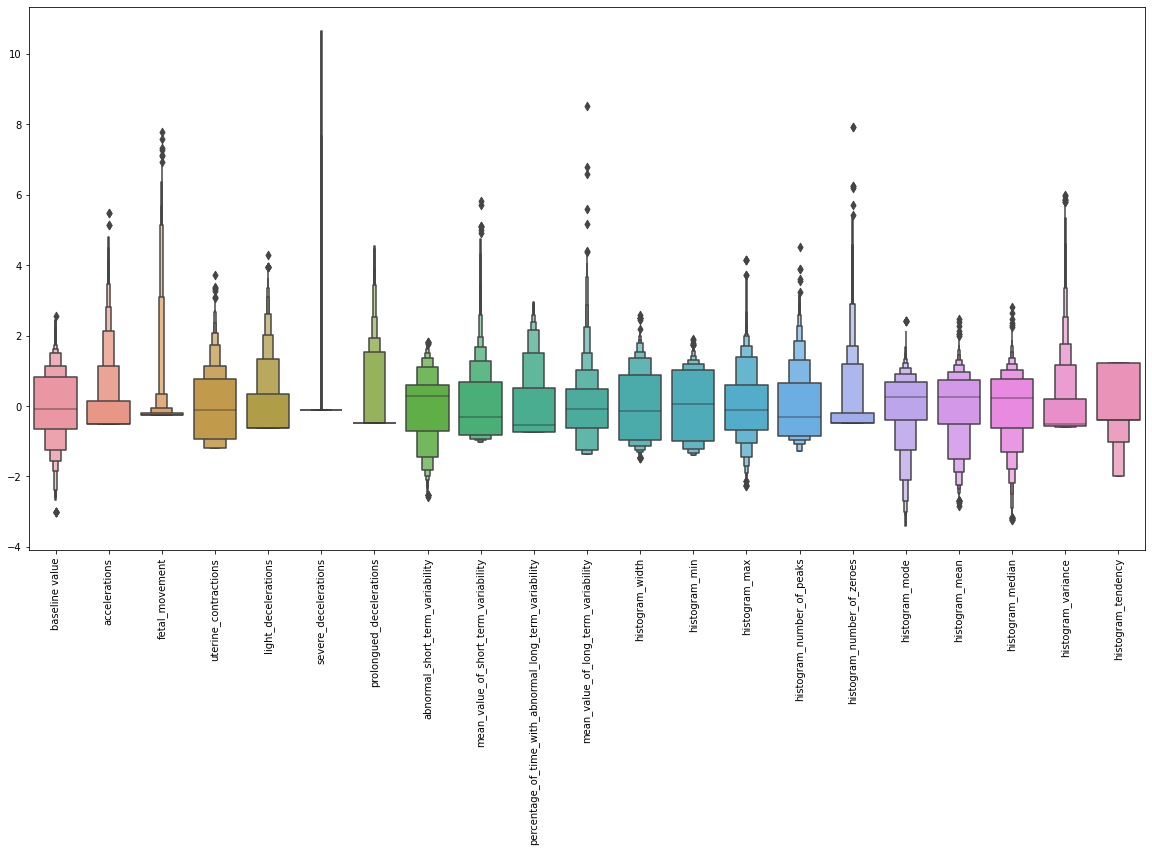

In [19]:
# Check the actual scaled version
plt.figure(figsize=(20,10))
sns.boxenplot(data = X_train)
plt.xticks(rotation=90)
plt.show()

# Model Evaluation

We will consider several model to solve the supervised problems. We will create some pipelines to make it simple.
- SVM (linear, poly, rbf, sigmoid)
- Naive Bayes
- KNN

Test set
1.0    496
2.0    101
3.0     41
Name: fetal_health, dtype: int64
Traning set
2.0    1159
1.0    1159
3.0    1159
Name: fetal_health, dtype: int64
SVM linear
              precision    recall  f1-score   support

         1.0       0.97      0.86      0.91       496
         2.0       0.54      0.75      0.63       101
         3.0       0.59      0.83      0.69        41

    accuracy                           0.84       638
   macro avg       0.70      0.81      0.74       638
weighted avg       0.88      0.84      0.85       638



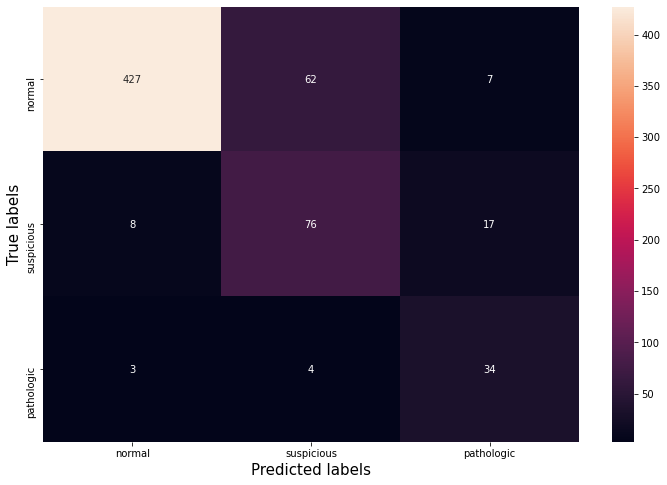

SVM poly
              precision    recall  f1-score   support

         1.0       0.98      0.86      0.91       496
         2.0       0.54      0.82      0.65       101
         3.0       0.73      0.85      0.79        41

    accuracy                           0.85       638
   macro avg       0.75      0.84      0.78       638
weighted avg       0.89      0.85      0.86       638



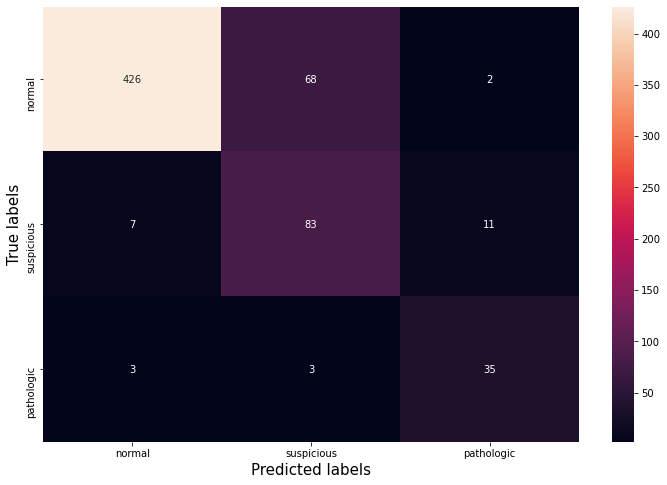

SVM rbf
              precision    recall  f1-score   support

         1.0       0.98      0.88      0.93       496
         2.0       0.57      0.80      0.67       101
         3.0       0.67      0.88      0.76        41

    accuracy                           0.86       638
   macro avg       0.74      0.85      0.78       638
weighted avg       0.90      0.86      0.87       638



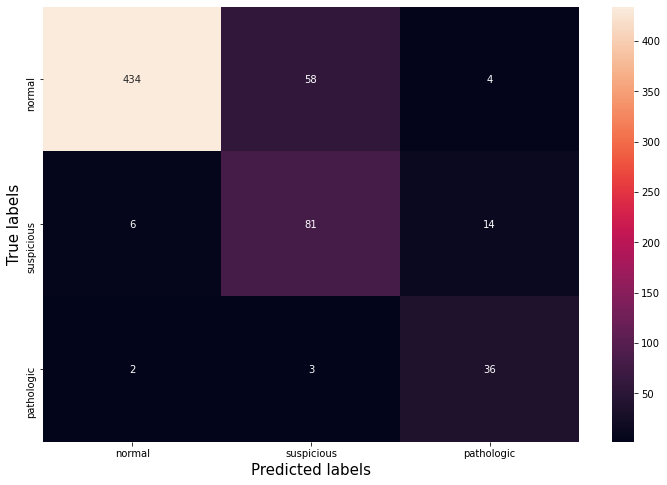

SVM sigmoid
              precision    recall  f1-score   support

         1.0       0.96      0.71      0.82       496
         2.0       0.50      0.70      0.58       101
         3.0       0.25      0.76      0.37        41

    accuracy                           0.71       638
   macro avg       0.57      0.72      0.59       638
weighted avg       0.84      0.71      0.75       638



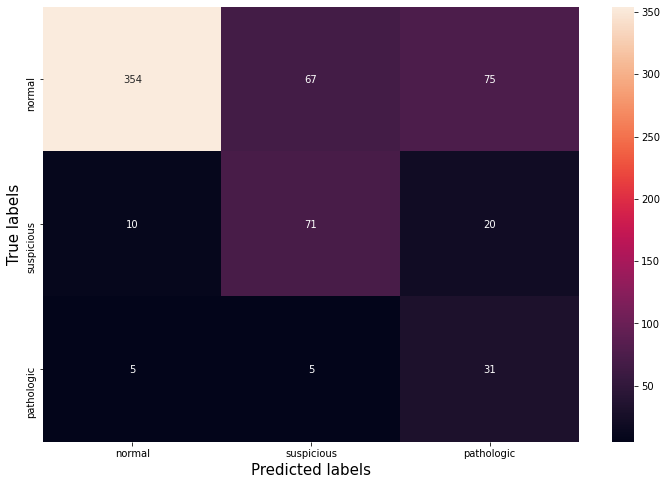

Gaussian NB
              precision    recall  f1-score   support

         1.0       0.99      0.66      0.79       496
         2.0       0.37      0.94      0.53       101
         3.0       0.48      0.61      0.54        41

    accuracy                           0.70       638
   macro avg       0.61      0.74      0.62       638
weighted avg       0.86      0.70      0.73       638



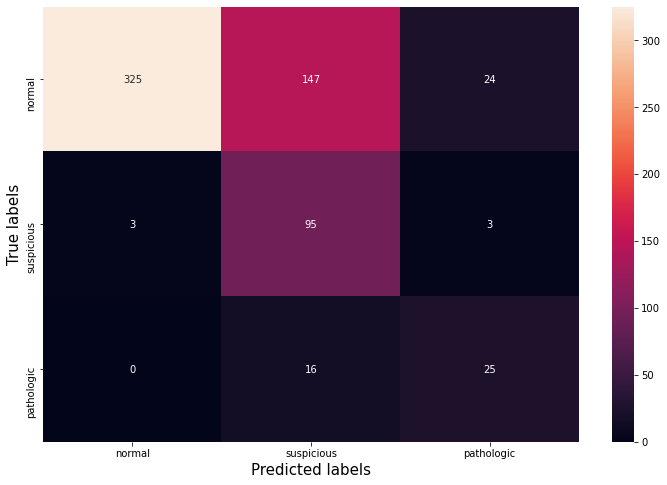

Logistic Regression
              precision    recall  f1-score   support

         1.0       0.98      0.86      0.91       496
         2.0       0.53      0.76      0.63       101
         3.0       0.55      0.80      0.65        41

    accuracy                           0.84       638
   macro avg       0.69      0.81      0.73       638
weighted avg       0.88      0.84      0.85       638



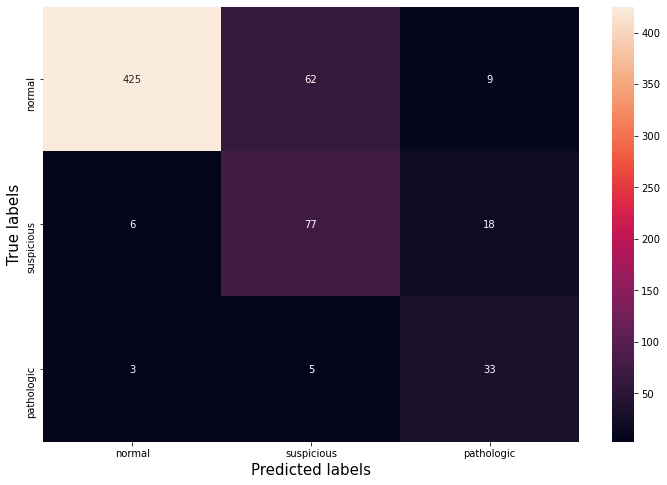

In [20]:
x_axis_labels = ['normal', 'suspicious', 'pathologic']
y_axis_labels = x_axis_labels

# Check balance test set and train set
print("Test set")
print(y_test.value_counts())
print("Traning set")
print(y_train.value_counts())

pipeline_svm_linear=Pipeline([('svm_classifier_linear',SVC(kernel='linear'))])
pipeline_svm_poly=Pipeline([('svm_classifier_poly',SVC(kernel='poly'))])
pipeline_svm_rbf=Pipeline([('svm_classifier_rbf',SVC(kernel='rbf'))])
pipeline_svm_sigmoid=Pipeline([('svm_classifier_sigmoid',SVC(kernel='sigmoid'))])
pipeline_gaussian=Pipeline([('gaussian_classifier',GaussianNB())])
pipeline_linear=Pipeline([('linear_classifier',LogisticRegression(max_iter=100000))])

pipelines = [
    pipeline_svm_linear, 
    pipeline_svm_poly, 
    pipeline_svm_rbf, 
    pipeline_svm_sigmoid,
    pipeline_gaussian,
    pipeline_linear,
]

pipe_dict = {
    0: 'SVM linear', 
    1: 'SVM poly', 
    2: 'SVM rbf', 
    3: "SVM sigmoid",
    4: "Gaussian NB",
    5: "Logistic Regression"
}

for pipe in pipelines:
    pipe.fit(X_train, y_train)

for i, model in enumerate(pipelines):
    predictions=model.predict(X_test)
    print("%s" % (pipe_dict[i]))
    print(classification_report(y_test, predictions))
    plt.subplots(figsize=(12,8))
    cf_matrix = confusion_matrix(y_test, predictions)
    sns.heatmap(cf_matrix, annot = True, fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    plt.xlabel('Predicted labels', fontsize=15)
    plt.ylabel('True labels', fontsize=15)
    plt.show()      
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    #plt.subplots(1, figsize=(10,10))
    #plt.title('Receiver Operating Characteristic')
    #false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, predictions)
    #plt.plot(false_positive_rate1, true_positive_rate1)
    #plt.plot([0, 1], ls="--")
    #plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    #plt.ylabel('True Positive Rate')
    #plt.xlabel('False Positive Rate')
    #plt.show()

# PCA analysis
We are going to analyse the possibility to reduce the dimensionality based on pca component analysis

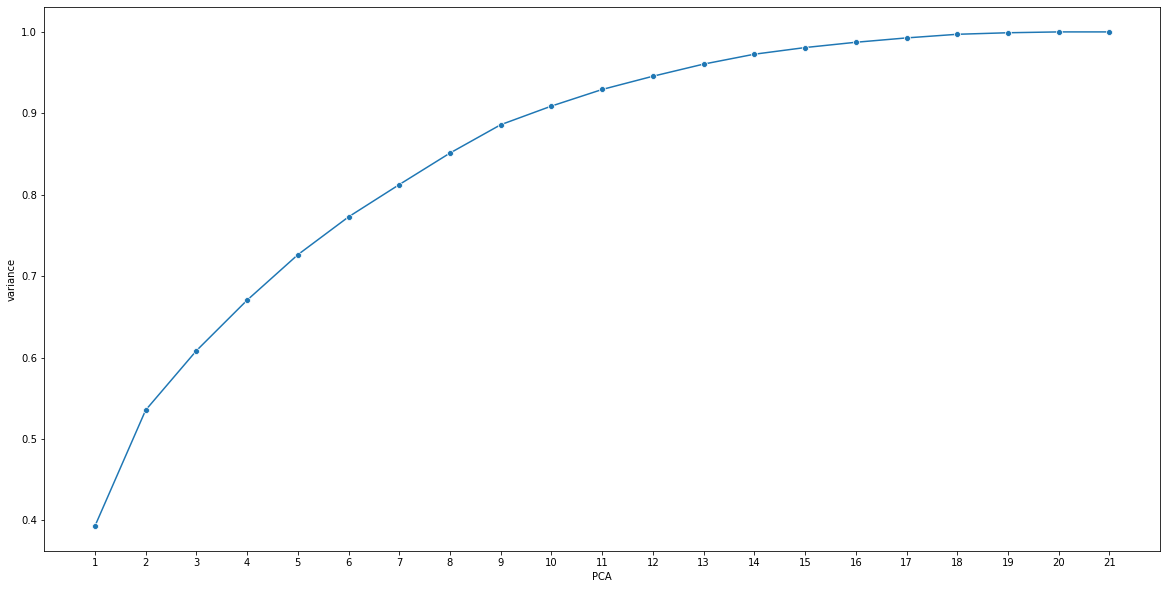

In [21]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X_train)
pca.transform(X_test)

pca_component = np.linspace(1,21,num=21)
tmp = pd.DataFrame(data={'variance': np.cumsum(pca.explained_variance_ratio_).tolist(), 'PCA': pca_component.tolist()})
plt.figure(figsize=(20,10))
ax = sns.lineplot(data=tmp, x='PCA', y='variance',marker='o',dashes=False)
ax.set(xticks=pca_component)
plt.show()

The last five components don't provide information at all so we can exclude them. Let's try some experiments with different number of components

In [22]:
for i in range(1,17):
    pca = PCA(n_components=i)
    X_train_reduced = pca.fit_transform(X_train)
    X_test_reduced = pca.transform(X_test)
    
    for pipe in pipelines:
        pipe.fit(X_train_reduced, y_train)

    tmp = np.zeros((len(pipelines), 4))
    a = []
    p = []
    r = []
    f1 = []
    for z, model in enumerate(pipelines):
        predictions=model.predict(X_test_reduced)
        acccuracy= accuracy_score(y_test,predictions)
        recall = recall_score(y_test, predictions, average="weighted", labels=np.unique(predictions))
        precision = precision_score(y_test, predictions, average="weighted",labels=np.unique(predictions))
        f1_scores = f1_score(y_test, predictions, average="weighted", labels=np.unique(predictions))
        a.append(acccuracy)
        p.append(precision)
        r.append(recall)
        f1.append(f1_scores)
    
    tmp = pd.DataFrame(data={'accuracy': a, 'precision': p, "recall": r, "f1 score": f1},
    index=['SVM linear', 'SVM poly', 'SVM rbf', "SVM sigmoid","Gaussian NB", "Logistic Regression"])
    print("Number of PCA components : ", i)
    print(tmp.to_string())

Number of PCA components :  1
                     accuracy  precision    recall  f1 score
SVM linear           0.601881   0.810161  0.601881  0.646855
SVM poly             0.805643   0.796581  0.805643  0.800322
SVM rbf              0.733542   0.825976  0.733542  0.759359
SVM sigmoid          0.545455   0.741444  0.545455  0.607897
Gaussian NB          0.633229   0.815010  0.633229  0.673530
Logistic Regression  0.479624   0.800903  0.479624  0.528744
Number of PCA components :  2
                     accuracy  precision    recall  f1 score
SVM linear           0.652038   0.809079  0.652038  0.692909
SVM poly             0.829154   0.831172  0.829154  0.828831
SVM rbf              0.775862   0.835691  0.775862  0.794026
SVM sigmoid          0.673981   0.743713  0.673981  0.699893
Gaussian NB          0.686520   0.821444  0.686520  0.719751
Logistic Regression  0.655172   0.806982  0.655172  0.694714
Number of PCA components :  3
                     accuracy  precision    recall  f1 s

From the analysis of the PCA components we don't have a clear benefit of using less components. With 17 components (excluding the last 5 components with pretty close to zero contribution) we reached a good level according to our metrics (even the use of 3/4 components might be acceptable). Anyway do to the fact that the training time is reasonable and pretty fast it is better to use the full dataset.

# LDA (Fisher) analysis
We are going to investigate the use of Fisher dimensionality reduction over our dataset

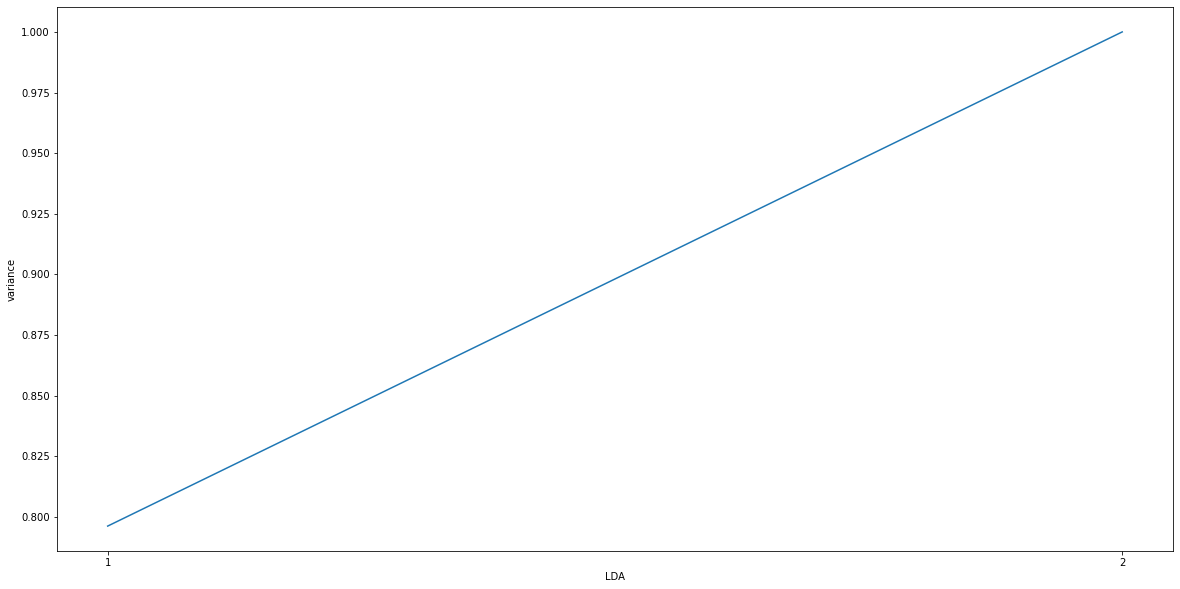

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
lda.fit_transform(X_train, y_train)
lda.transform(X_test)

lda_component = np.linspace(1,2,num=2)
tmp = pd.DataFrame(data={'variance': np.cumsum(lda.explained_variance_ratio_).tolist(), 'LDA': lda_component.tolist()})
plt.figure(figsize=(20,10))
ax = sns.lineplot(data=tmp, x='LDA', y='variance', markers=True,dashes=False)
ax.set(xticks=lda_component)
plt.show()

In [24]:
for i in range(1,3):
    lda = LDA(n_components=i)
    X_train_reduced_lda = lda.fit_transform(X_train, y_train)
    X_test_reduced_lda = lda.transform(X_test)

    for pipe in pipelines:
        pipe.fit(X_train_reduced_lda, y_train)

    tmp = np.zeros((len(pipelines), 4))
    a = []
    p = []
    r = []
    f1 = []
    for z, model in enumerate(pipelines):
        predictions=model.predict(X_test_reduced_lda)
        acccuracy= accuracy_score(y_test,predictions)
        recall = recall_score(y_test, predictions, average="weighted", labels=np.unique(predictions))
        precision = precision_score(y_test, predictions, average="weighted",labels=np.unique(predictions))
        f1_scores = f1_score(y_test, predictions, average="weighted", labels=np.unique(predictions))
        a.append(acccuracy)
        p.append(precision)
        r.append(recall)
        f1.append(f1_scores)
    
    tmp = pd.DataFrame(data={'accuracy': a, 'precision': p, "recall": r, "f1 score": f1},
    index=['SVM linear', 'SVM poly', 'SVM rbf', "SVM sigmoid","Gaussian NB", "Logistic Regression"])
    print("Number of LDA components : ", i)
    print(tmp.to_string())

Number of LDA components :  1
                     accuracy  precision    recall  f1 score
SVM linear           0.714734   0.837108  0.714734  0.750828
SVM poly             0.670846   0.840722  0.670846  0.713311
SVM rbf              0.705329   0.834305  0.705329  0.743131
SVM sigmoid          0.648903   0.807980  0.648903  0.701383
Gaussian NB          0.719436   0.836067  0.719436  0.754506
Logistic Regression  0.721003   0.834183  0.721003  0.755471
Number of LDA components :  2
                     accuracy  precision    recall  f1 score
SVM linear           0.807210   0.875602  0.807210  0.826031
SVM poly             0.735110   0.875852  0.735110  0.767307
SVM rbf              0.777429   0.866503  0.777429  0.802292
SVM sigmoid          0.753918   0.839742  0.753918  0.780698
Gaussian NB          0.785266   0.869050  0.785266  0.806989
Logistic Regression  0.794671   0.859961  0.794671  0.813926


LDA doesn't provide great results in fact in case of uniformly distributed data, LDA almost always performs better than PCA. However if the data is highly skewed (irregularly distributed) then it is advised to use PCA since LDA can be biased towards the majority class.

# KNN (Model evaluation and K selection)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

a = []
p = []
r = []
f1 = []
for neighbors in range(1,35):
    pipeline_knn = Pipeline([('knn_classifier',KNeighborsClassifier(n_neighbors=neighbors))])
    pipeline_knn.fit(X_train, y_train)

    tmp = np.zeros((1, 4))
    for z, model in enumerate(pipeline_knn):
        predictions=model.predict(X_test)
        acccuracy= accuracy_score(y_test,predictions)
        recall = recall_score(y_test, predictions, average="weighted", labels=np.unique(predictions))
        precision = precision_score(y_test, predictions, average="weighted",labels=np.unique(predictions))
        f1_scores = f1_score(y_test, predictions, average="weighted", labels=np.unique(predictions))
        a.append(acccuracy)
        p.append(precision)
        r.append(recall)
        f1.append(f1_scores)

tmp = pd.DataFrame(data={'accuracy': a, 'precision': p, "recall": r, "f1 score": f1})
plt.figure(figsize=(20,10))
ax = sns.lineplot(data=tmp)
ax.set(xlabel='K-neighbors', ylabel='Metric Performance')
plt.show()

# Let's see clearly the performances of k = 2,3,4 to see if there is an improvement
for neighbors in range(2,5):
    pipeline_knn = Pipeline([('knn_classifier',KNeighborsClassifier(n_neighbors=neighbors))])
    pipeline_knn.fit(X_train, y_train)

    for z, model in enumerate(pipeline_knn):
        predictions=model.predict(X_test)
        print("KNN with K = ", neighbors)
        print(classification_report(y_test, predictions))
        plt.subplots(figsize=(12,8))
        cf_matrix = confusion_matrix(y_test, predictions)
        sns.heatmap(cf_matrix, annot = True, fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
        plt.xlabel('Predicted labels', fontsize=15)
        plt.ylabel('True labels', fontsize=15)
        plt.show()

The KNN works pretty well with K = 2 or K = 4

# Artificial Neural Networks (ANN)
We will investigate the use of artificial neural networks even though the number of samples is pretty limited. We don't expect to see better results but they should not be that bad.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 21
hidden_size = 100
num_classes = 3
num_epochs = 100
batch_size = 50
learning_rate = 0.001

train_losses=[]
train_accu=[]
test_losses=[]
test_accu=[]

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    return torch.from_numpy(df.values).float().to(device)

def df_to_tensor_long(df):
    # Put -1 to have 3 classes from 0 to 2
    return torch.from_numpy(df.values-1).long().to(device)

train_dataset = torch.utils.data.TensorDataset(df_to_tensor(X_train), df_to_tensor_long(y_train))
test_dataset = torch.utils.data.TensorDataset(df_to_tensor(X_test),df_to_tensor_long(y_test))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    running_loss=0
    correct=0
    total=0
    model.train()
    
    for i, (val, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        val = val.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(val)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #if (i+1) % 10 == 0:
            #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
            #       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        running_loss += loss.item()
    
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
      
    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total

    train_accu.append(accu)
    train_losses.append(train_loss)
    
    for val, labels in test_loader:
        val = val.to(device)
        labels = labels.to(device)
        outputs = model(val)
        loss = criterion(outputs,labels)
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    test_loss=running_loss/len(train_loader)
    accu=100.*correct/total

    test_accu.append(accu)
    test_losses.append(test_loss)

def flatten(t):
    return [item for sublist in t for item in sublist]

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency) 
with torch.no_grad():
    correct = 0
    total = 0
    p = []
    r = []
    for val, labels in test_loader:
        val = val.to(device)
        labels = labels.to(device)
        outputs = model(val)
        _, predicted = torch.max(outputs.data, 1)
        
        p.append(predicted.flatten().tolist())
        r.append(labels.flatten().tolist())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(classification_report(flatten(r),flatten(p)))
    plt.subplots(figsize=(12,8))
    cf_matrix = confusion_matrix(flatten(r), flatten(p))
    sns.heatmap(cf_matrix, annot = True, fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    plt.xlabel('Predicted labels', fontsize=15)
    plt.ylabel('True labels', fontsize=15)
    plt.show() 
    print('Accuracy of the network on the test data: {} %'.format(100 * correct / total))

plt.plot(train_accu,'-o')
plt.plot(test_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.title('Train/Test Accuracy')
plt.show()

plt.plot(train_losses,'-o')
plt.plot(test_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train', 'Test'])
plt.title('Train/Test Losses')
plt.show()

# Semisupervised problem
Let's try to solve the semisupervised problem using SVM

In [ ]:
from sklearn.multiclass import OneVsOneClassifier

num_train_samples = 300
max_iter = 1000
samples_per_class = int(num_train_samples/3)
print("samples per class ", samples_per_class)
unique_classes = np.unique(y_train)

subsample_idx = [np.random.choice(np.where(y_train == mnist_class)[0], size=samples_per_class, replace=False) for mnist_class in unique_classes]
subsample_idx = np.array(subsample_idx).flatten()
unlabeled_mask = np.ones(y_train.size, dtype=bool)
unlabeled_mask[subsample_idx] = False

x_labeled = X_train.to_numpy()[subsample_idx, :]
x_unlabeled = X_train.to_numpy()[unlabeled_mask, :]
y_labeled, y_unlabeled = y_train.to_numpy()[subsample_idx], y_train.to_numpy()[unlabeled_mask]

print("Labeled dataset ", x_labeled.shape)
print("Unlabeled dataset", x_unlabeled.shape)
# y_labeled.shape, y_unlabeled.shape

classifier = OneVsOneClassifier(SVC(kernel='rbf', max_iter=max_iter, random_state=42)).fit(x_labeled, y_labeled)
predictions = classifier.predict(X_test)
print(classification_report(y_test, predictions))
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix, annot = True, fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted labels', fontsize=15)
plt.ylabel('True labels', fontsize=15)
plt.show()


pseudo_labels = classifier.predict(x_unlabeled)
pseudo_train = np.vstack((x_labeled, x_unlabeled))
pseudo_test = np.vstack((y_labeled.reshape(-1, 1), pseudo_labels.reshape(-1, 1))).flatten()

pseudo_classifier = OneVsOneClassifier(SVC(kernel='rbf',max_iter=max_iter, random_state=42)).fit(pseudo_train, pseudo_test)
predictions = pseudo_classifier.predict(X_test)
print("Semisupervised problem")
print(classification_report(y_test, predictions))
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix, annot = True, fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted labels', fontsize=15)
plt.ylabel('True labels', fontsize=15)
plt.show()

classifier = OneVsOneClassifier(SVC(kernel='rbf',max_iter=max_iter, random_state=42)).fit(X_train, y_train)
predictions = classifier.predict(X_test)
print("Fully supervised problem")
print(classification_report(y_test, predictions))
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix, annot = True, fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted labels', fontsize=15)
plt.ylabel('True labels', fontsize=15)
plt.show()

# Feature Selection and Model Evaluation
Try to repeat the same process selecting features with high correlation and evaluate the results

In [ ]:
# Select feature with more than 10% of correlation with fetal_health
print(corrmat[abs(corrmat['fetal_health']) > 0.3]['fetal_health'])
x = data[corrmat[abs(corrmat['fetal_health']) > 0.3]['fetal_health'].index]
x_dropped = x.drop(["fetal_health"], axis=1)
p = []
r = []
X_corr = (x_dropped-x_dropped.mean())/x_dropped.std()
y_corr = data['fetal_health']
sm = SMOTE(random_state=42)
X_corr, y_corr = sm.fit_resample(X_corr,  y_corr)
print(X_corr.shape)
print(y_corr.shape)

In [ ]:
X_train, X_test, y_train,y_test = train_test_split(X_corr,y_corr,test_size=0.4,random_state=42)

pipeline_svm_linear=Pipeline([('svm_classifier_linear', SVC(kernel='linear'))])
pipeline_svm_poly=Pipeline([('svm_classifier_poly',SVC(kernel='poly'))])
pipeline_svm_rbf=Pipeline([('svm_classifier_rbf',SVC(kernel='rbf'))])
pipeline_svm_sigmoid=Pipeline([('svm_classifier_sigmoid',SVC(kernel='sigmoid'))])
pipeline_gaussian=Pipeline([('gaussian_classifier',GaussianNB())])
pipeline_linear=Pipeline([('linear_classifier',LogisticRegression(max_iter=100000))])

pipelines = [
    pipeline_svm_linear, 
    pipeline_svm_poly, 
    pipeline_svm_rbf, 
    pipeline_svm_sigmoid,
    pipeline_gaussian,
    pipeline_linear,
]

pipe_dict = {
    0: 'SVM linear', 
    1: 'SVM poly', 
    2: 'SVM rbf', 
    3: "SVM sigmoid",
    4: "Gaussian NB",
    5: "Logistic Regression"
}

for pipe in pipelines:
    pipe.fit(X_train, y_train)

for i, model in enumerate(pipelines):
    predictions=model.predict(X_test)
    print("%s" % (pipe_dict[i]))
    print(classification_report(y_test, predictions))
    plt.subplots(figsize=(12,8))
    cf_matrix = confusion_matrix(y_test, predictions)
    sns.heatmap(cf_matrix, annot = True, fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    plt.xlabel('Predicted labels', fontsize=15)
    plt.ylabel('True labels', fontsize=15)
    plt.show()